In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
%matplotlib inline

from lib.health import DepartmentOfHealth, GlobalContext
from lib.observer import Observer
from lib.logger import Logger
from lib.deseases import get_infectable, InfectableType
from lib.simulation import simulate_day, create_hospitals, create_persons


def initialize():
    # our little country
    min_i, max_i = 0, 100
    min_j, max_j = 0, 100

    # our citizen
    n_persons = 1000
    persons = create_persons(min_j, max_j, min_i, max_i, n_persons)

    # our healthcare system
    n_hospitals = 4
    hospitals = create_hospitals(n_hospitals, capacity=80)

    health_dept = DepartmentOfHealth(hospitals)
    observer = Observer(persons + [health_dept])
    logger = Logger(print_info=False)

    # global context
    context = GlobalContext((min_j, max_j, min_i, max_i), persons, health_dept, observer)

    for person in persons:
        if random.random() < 0.05:
            person.state.get_infected(get_infectable(InfectableType.SARSCoV2))
            
    for person in persons:
        if random.random() < 0.01:
            person.state.get_infected(get_infectable(InfectableType.Cholera))
            
    for person in persons:
        if random.random() < 0.05:
            person.state.get_infected(get_infectable(InfectableType.SeasonalFlu))


    return context

## Run simulation

In [2]:
random.seed(42)
context = initialize()

for i in tqdm.trange(100):
    simulate_day(context)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


## Individual infection statistics

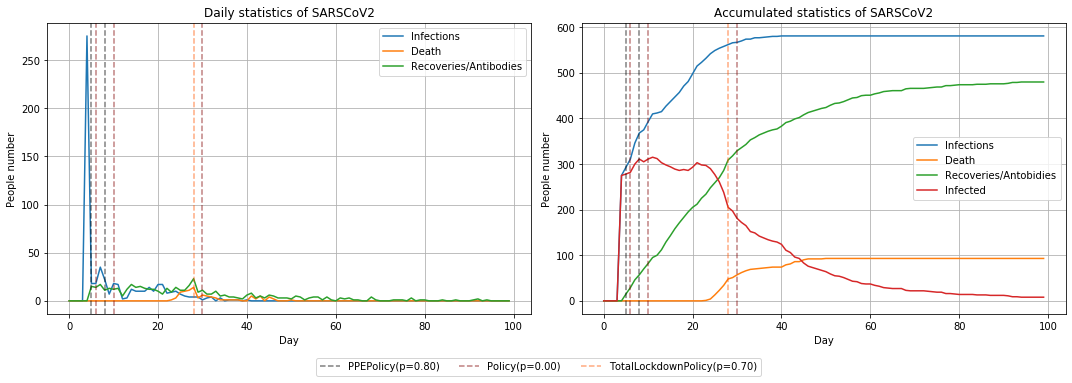

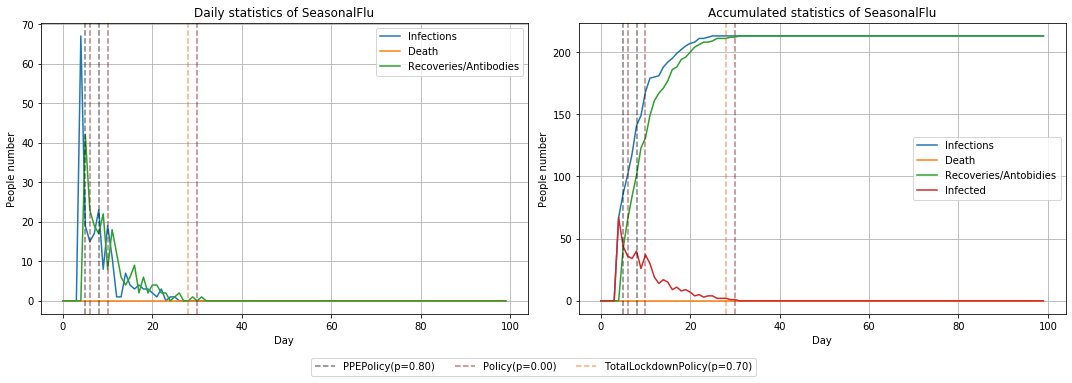

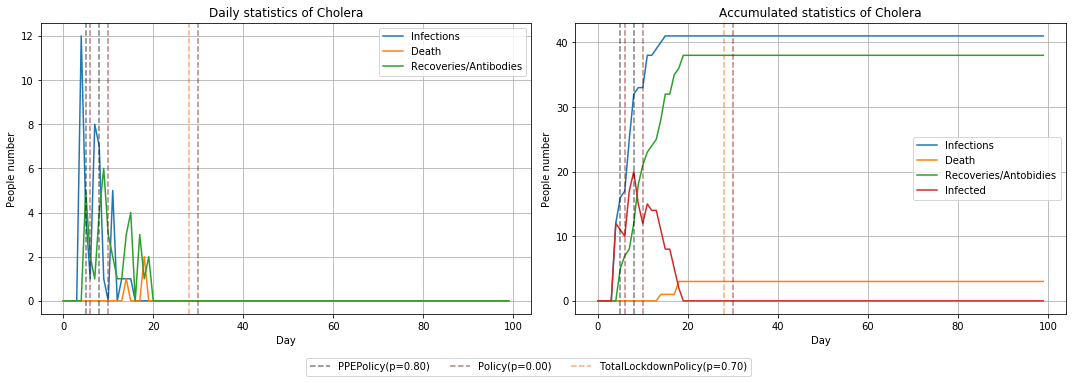

In [3]:
def infection_plot(df, infection_type):
    if 'infected_{}'.format(infection_type) not in df.columns:
        print('No {} viruses in simulation'.format(infection_type))
        return
    
    plt.figure(figsize=(15, 5))
    cmap = mpl.cm.get_cmap('gist_heat')

    plt.subplot(121)
    plt.title('Daily statistics of {}'.format(infection_type))
    plt.xlabel('Day')
    plt.ylabel('People number')

    plt.plot(df['day'], df['infected_{}'.format(infection_type)], label='Infections')
    plt.plot(df['day'], df['dead_{}'.format(infection_type)], label='Death')
    # Since according to model number of recoveries equal to number of people with antibodies (Death is not recovery)
    plt.plot(df['day'], df['recovered_{}'.format(infection_type)], label='Recoveries/Antibodies')


    policies_hist = GlobalContext().observer.policies
    unique_policies = set([x[1] for x in policies_hist])
    policies_dict = {policy: i for i, policy in enumerate(unique_policies)}

    for i, (day, policy) in enumerate(policies_hist):
        plt.axvline(day, c=cmap(float(policies_dict[policy])/len(unique_policies)), linestyle='--', alpha=0.5)

    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.title('Accumulated statistics of {}'.format(infection_type))
    l1 = plt.plot(df['day'], np.cumsum(df['infected_{}'.format(infection_type)]), label='Infections')
    l2 = plt.plot(df['day'], np.cumsum(df['dead_{}'.format(infection_type)]), label='Death')
    # Since according to model number of recoveries equal to number of people with antibodies (Death is not recovery)
    l3 = plt.plot(df['day'], np.cumsum(df['recovered_{}'.format(infection_type)]), label='Recoveries/Antobidies') 
    infected_cur = np.cumsum(df['infected_{}'.format(infection_type)]) - np.cumsum(df['dead_{}'.format(infection_type)]) - np.cumsum(df['recovered_{}'.format(infection_type)])
    l4 = plt.plot(df['day'], infected_cur, label='Infected')
    plt.xlabel('Day')
    plt.ylabel('People number')
    leg = plt.legend(handles=l1+l2+l3+l4)
    plt.grid()

    handles = []
    handle_types = set()
    for i, (day, policy) in enumerate(policies_hist):
        cur = plt.axvline(day, c=cmap(float(policies_dict[policy])/len(unique_policies)), linestyle='--', alpha=0.5, label=str(policy))
        if policy not in handle_types:
            handles.append(cur)
            handle_types.add(policy)

    plt.tight_layout()
    plt.legend(handles=handles, bbox_to_anchor=(-0.55, -0.15), loc='upper left', borderaxespad=0., ncol=len(handles))
    plt.gca().add_artist(leg)
    

df = GlobalContext().observer.export_df()
infection_plot(df, infection_type='SARSCoV2')
infection_plot(df, infection_type='SeasonalFlu')
infection_plot(df, infection_type='Cholera')

There are 3 different policies:
* No policy, infections are possible and people move during day
* Total lockdown policy is appied when daily death is 1% of population. 70% of population abide policy and sit home during day
* PPE (gloves,masks,...) wearing policy is applied when considerable number of daily infections detected. PPE prevent infection. 80% of population abide policy. 

Implemented but not issued by goverment:
* DistrictLockdownPolicy(max_dist, strength). Only small movements of people (dist < max_dist) are accepted. 

## Global statistics

In [4]:
total = {}

for virus_type in ['SARSCoV2', 'Cholera', 'SeasonalFlu']:
    for stat_type in ['infected', 'dead', 'recovered', 'ab']:
        if stat_type + '_'+virus_type not in df.columns:
            break
        if stat_type in total:
            total[stat_type] = total[stat_type] + df[stat_type+'_'+virus_type]
        else:
            total[stat_type] = df[stat_type+'_'+virus_type]

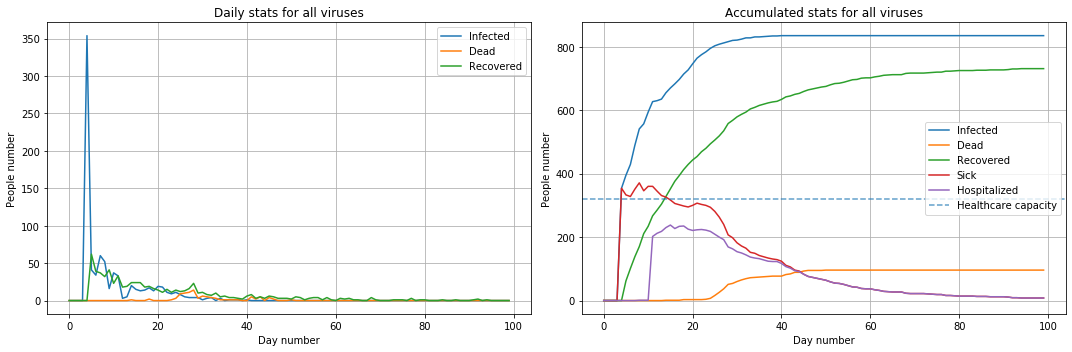

In [5]:
days = total['infected'].index

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Daily stats for all viruses')
plt.plot(days, total['infected'], label='Infected')
plt.plot(days, total['dead'], label='Dead')
plt.plot(days, total['recovered'], label='Recovered')
#plt.plot(days, total['ab'], label='Antobodies')
plt.grid()
plt.legend()
plt.xlabel('Day number')
plt.ylabel('People number')

plt.subplot(122)
plt.title('Accumulated stats for all viruses')
plt.plot(days, np.cumsum(total['infected']), label='Infected')
plt.plot(days, np.cumsum(total['dead']), label='Dead')
plt.plot(days, np.cumsum(total['recovered']), label='Recovered')
#plt.plot(days, np.cumsum(total['ab']), label='Antobodies')

plt.plot(days, np.cumsum(total['infected'])-np.cumsum(total['dead'])-np.cumsum(total['recovered']), label='Sick')

plt.plot(days, np.cumsum(df['hospitalized']), label='Hospitalized')
total_capacity = sum([x.capacity for x in GlobalContext().health_dept.hospitals])
plt.axhline(total_capacity, linestyle='--', alpha=0.7, label='Healthcare capacity')
plt.grid()
plt.legend()

plt.xlabel('Day number')
plt.ylabel('People number')


plt.tight_layout()